# PCA 
- <strong style="color:#FFC107"> Sau khi sử dụng Conv để trích xuất ra đặc trưng của ảnh , tiếp đến làm phẳng bằng Flatten sau đó cho quan PCA để giảm chiều trước khi cho vào model để huấn luyện . </strong>
- <strong style="color:#FFC107"> Tranfer learning feature extractor sẽ dễ kết hợp với PCA hơn là Fine tuning vì fine tuning phải xây một kiến trúc cố dịnh </strong>

#### 0. Tóm tắt các bước tiến hành 
1. Lấy ra toàn bộ ảnh trong dataset , chuyển ảnh về ma trận 224x224x3 là kích thước đầu vào của VGG16 
2. Trích xuất đặc trưng của các ảnh bằng cách cho tập ma trận của ảnh đi qua "model VGG16 của thư viện , bỏ đi lớp FC ở cuối"
3. <strong style="color:#FFC107">Thêm PCA vào đây</strong>
4. Sau khi có được tập đặc trưng và label tương ứng , chia tập thành train , test , val 
5. Tạo ra model của riêng mình và huấn luyện nó : 
    - model = GridSearchCV(LogisticRegression(), params) 
    - model.fit(X_train, y_train)
6. Sau khi có model huấn đánh giá lại bằng tập test 

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report , confusion_matrix
from imutils import paths
from keras.applications import VGG16
from sklearn.decomposition import PCA
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#### Chuẩn bị dữ liệu

In [25]:
# Lấy các đường dẫn đến ảnh.
image_path = list(paths.list_images('dataset/'))
# print(image_path)
# Đổi vị trí ngẫu nhiên các đường dẫn ảnh
random.shuffle(image_path)

In [26]:
# Đường dẫn ảnh sẽ là dataset/tên_loài_hoa/tên_ảnh ví dụ dataset/Bluebell/image_0241.jpg nên p.split(os.path.sep)[-2] sẽ lấy ra được tên loài hoa
labels = [p.split(os.path.sep)[-2] for p in image_path]
# print(labels)
# Chuyển tên các loài hoa thành số
le = LabelEncoder()
labels = le.fit_transform(labels)

In [27]:
# Load ảnh và resize về đúng kích thước mà VGG 16 cần là (224,224)
list_image = []
for (j, imagePath) in enumerate(image_path):
    # Load ảnh và resize về kích thước (224, 224)
    image = load_img(imagePath, target_size=(224, 224))
    
    # Chuyển ảnh thành mảng numpy
    image = img_to_array(image)
    # print(image.shape) # (224, 224, 3)
    
    # Mở rộng chiều của mảng numpy
    image = np.expand_dims(image, 0)
    # print(image.shape) # (1, 224, 224, 3)
    
    # # Tiền xử lý ảnh theo tiêu chuẩn của mô hình VGG16
    # image = imagenet_utils.preprocess_input(image)
    # # print(image.shape) # (1, 224, 224, 3)
    
    # Thêm ảnh đã tiền xử lý vào danh sách
    list_image.append(image)
    
# Chuyển danh sách các ảnh thành mảng numpy một chiều
list_image = np.vstack(list_image)


In [28]:
print(list_image.shape)
# print(list_image[0]) # ma trận w.h.d của ảnh là input đầu vào của model 
# print(list_image[0].shape)

(1360, 224, 224, 3)


#### Lớp cuối cùng Conv VGG16 = 7x7x512 

In [29]:
# model = VGG16(weights='imagenet')
# model.summary()
model_VGG16 = VGG16(weights='imagenet', include_top=False)

In [30]:
# Dùng pre-trained model để lấy ra các feature của ảnh 
features = model_VGG16.predict(list_image) # tensor Đặc trưng ảnh 

43/43 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step


In [31]:
features.shape

(1360, 7, 7, 512)

#### Làm phẳng tensor thành vector (Tương tự Flatten của Model)

In [32]:
features = features.reshape((features.shape[0], 512*7*7))
features.shape # (1360, 25088) . 7x7x512 = 25088

(1360, 25088)

#### <strong style="color:yellow">Giảm chiều bằng PCA</strong>

##### Giảm chiều nhưng explained_variance_ratio từ 95% - 99%

In [33]:
pca = PCA(n_components=0.95)  # Giữ lại 95% phương sai
# pca = PCA(n_components=k)  # Giảm xuống k chiều 

In [34]:
features_reduced = pca.fit_transform(features)
features_reduced.shape # (1360, 908)

(1360, 908)

#### Giữ lại 95% phương sai thì 25088 giảm xuống thấp nhất là 908 chiều . Ta thấy khá là thấp nhưng vẫn giữ lại được 95% phương sai . Mặc khác vector có 908 chiều thì train model nhanh hơn rất nhiều so với 25088 chiều 

#### Nếu Giảm xuống 908 chiều mà giữ lại được 95% thì nếu ta giảm 1/2 hoặc 1/4 thì chắc chắn phương sai giữ lại > 95%

### Train Model

#### Thật ra với Transfer learning thì chỉ nên chia train và test = 8 : 2 , không nên chia thêm valid . 

In [35]:
X_train, X_remain, y_train, y_remain = train_test_split(features_reduced, labels, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.33, random_state=42)
print(X_train.shape) # (1088, 908)
print(X_valid.shape) # (182, 908)
print(X_test.shape) # (90, 908)
# train : valid : test = 7 : 2 : 1 

(1088, 908)
(182, 908)
(90, 908)


In [36]:
params = {'C' : [0.1, 1.0, 10.0, 100.0]}
model = GridSearchCV(LogisticRegression(), params) 
model.fit(X_train, y_train) # HUẤN LUYỆN MODEL 
# Đánh giá mô hình trên tập validation
validation_score = model.score(X_valid, y_valid)
print('Best parameter for the model {}'.format(model.best_params_)) 
print("Best parameters for the model:", model.best_params_)
print("Best estimator:", model.best_estimator_)
print('Validation score:', validation_score)

Best parameter for the model {'C': 100.0}
Best parameters for the model: {'C': 100.0}
Best estimator: LogisticRegression(C=100.0)
Validation score: 0.8956043956043956


In [37]:
# Đánh giá model
preds = model.predict(X_test) # DỰ ĐOÁN VÀ ĐÁNH GIÁ 
# print(preds) # nhãn dưới dạng số 
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      1.00      1.00         6
           2       1.00      0.75      0.86         4
           3       0.57      1.00      0.73         4
           4       1.00      0.62      0.77         8
           5       0.75      0.60      0.67         5
           6       0.88      1.00      0.93         7
           7       0.00      0.00      0.00         0
           8       1.00      1.00      1.00         4
           9       0.83      1.00      0.91        10
          10       0.80      0.80      0.80         5
          11       1.00      0.88      0.93         8
          12       0.80      1.00      0.89         4
          13       1.00      0.86      0.92         7
          14       1.00      1.00      1.00         4
          15       0.67      0.33      0.44         6
          16       1.00      1.00      1.00         3

    accuracy              

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [38]:
# Lấy ra mô hình tốt nhất từ GridSearchCV
best_model = model.best_estimator_
# Đánh giá mô hình tốt nhất trên tập kiểm tra
score = best_model.score(X_test, y_test)
print("Accuracy on test set:", score)

Accuracy on test set: 0.8555555555555555


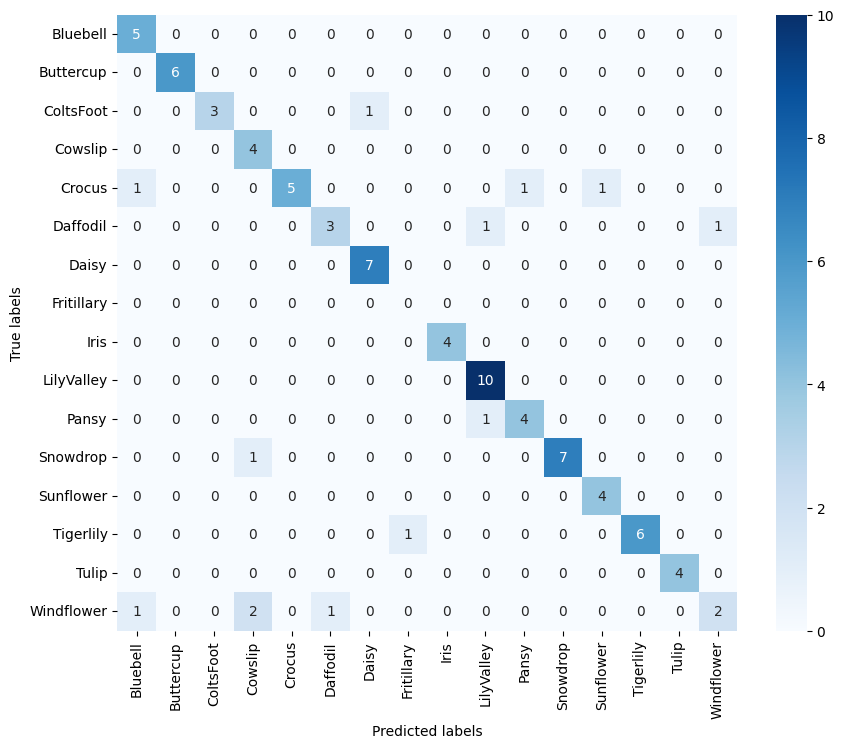

In [39]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, preds)

# Chuyển nhãn số thành tên loài hoa
label_names = le.inverse_transform(np.unique(y_test))
label_names = [label.split('/')[-1] for label in label_names]

# Sắp xếp lại ma trận nhầm lẫn
sorted_cm = cm[np.argsort(label_names)][:, np.argsort(label_names)]

# Tạo dataframe từ ma trận nhầm lẫn đã sắp xếp lại
df_cm = pd.DataFrame(sorted_cm, index=label_names, columns=label_names)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


#### Lưu ý : Không nên chia dữ liệu theo kiểu này vì nó không phù hợp với Feature Extractor  

In [ ]:
img_size = (224 , 224) # resize về đúng kích thước mà VGG 16 cần là (224,224)
batch_size = 8
img_shape = (img_size[0] , img_size[1] , 3)

# làm giàu dữ liệu data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)  # Chỉ rescale cho dữ liệu kiểm tra
# làm giàu dữ liệu data augmentation

train_gen = train_datagen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = test_datagen.flow_from_directory(val_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = test_datagen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)